# Metody probabilistyczne

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Ryzyko kredytowe

Każda instytucja udzielająca kredytu musi szacować zdolność kredytową i prawdopodobieństwo, czy dana osoba spłaci kredyt. W praktyce większość osób płaci prawidłowo, więc zamiast tego przewiduje się prawdopodobieństwo, że ktoś będzie miał opóźnienia w płatności w określonym czasie, tzw. **probability of default**. Jak sama nazwa wskazuje, nie jest to klasyfikacja binarna, tylko faktyczne prawdopodobieństwo, wykorzystywane przy ocenie ryzyka.

Wykorzystamy zbiór z konkursu [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/overview). Jego zmienne to ([źródło](https://www.listendata.com/2019/08/datasets-for-credit-risk-modeling.html)):
- `SeriousDlqin2yrs` - brak spłaty raty kredytu przez 90 dni lub dłużej w ciągu ostatnich 2 lat; są to nasze klasy `y`
- `RevolvingUtilizationOfUnsecuredLines` - aktualne zapożyczenie na kartach kredytowych i pożyczkach w stosunku do maksymalnego możliwego zapożyczenia
- `age` - wiek w latach
- `DebtRatio` - aktualne całkowite zapożyczenie względem miesięcznego dochodu
- `MonthlyIncome` - miesięczne dochody
- `NumberOfOpenCreditLinesAndLoans` - liczba aktualnych pożyczek i kart kredytowych
- `NumberOfTimes90DaysLate` - ile razy w przeszłości wystąpiło opóźnienie 90 dni lub dłużej w spłacie raty kredytu
- `NumberRealEstateLoansOrLines` - liczba pożyczek z nieruchomością jako zabezpieczeniem
- `NumberOfDependents` - liczba pozostałych osób w gospodarstwie domowym
- `NumberOfTime30-59DaysPastDueNotWorse` - ile razy w ciągu ostatnich 2 lat nastąpiło opóźnienie w spłacie raty między 30 a 59 dni
- `NumberOfTime60-89DaysPastDueNotWorse` - jak wyżej, ale 60-89 dni

Ze względu na potrzebę precyzyjnych prawdopodobieństw oraz rozmiar danych (banki mają ogromną liczbę klientów), regresja logistyczna to idealny wybór dla tego zadania. Metryką w takich przypadkach jest AUROC (Area Under Receiver Operating Characteristic curve), bo bierze ona pod uwagę prawdopodobieństwo klasy pozytywnej.

Na początek wczytamy i przeanalizujemy wstępnie nasze dane. Jako zbiór testowy wykorzystamy 20% danych. Jako że mamy do czynienia z klasyfikacją niezbalansowaną, to wykorzystamy **podział ze stratyfikacją (stratified split)**, w którym proporcje klasy pozytywnej i negatywnej zostają zachowane w zbiorze treningowym i testowym.

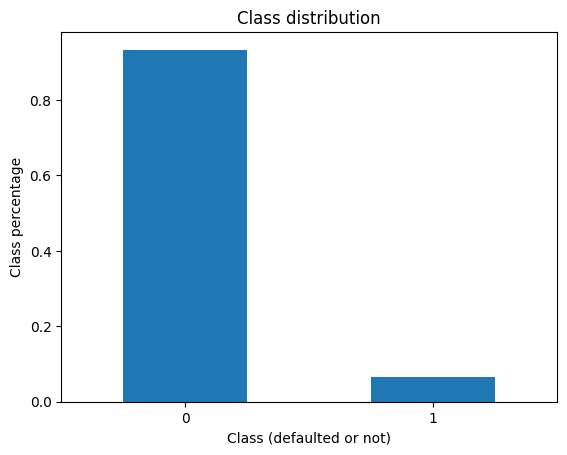

In [2]:
from sklearn.model_selection import train_test_split


df = pd.read_parquet("give_me_some_credit_data.parquet")
y = df.pop("SeriousDlqin2yrs")
X = df

y.value_counts(normalize=True).plot.bar(
    title="Class distribution", 
    rot=0, 
    xlabel="Class (defaulted or not)", 
    ylabel="Class percentage"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Jako że naszych zmiennych nie jest zbyt wiele, możemy łatwo zweryfikować statystyki naszych danych z pomocą metod `.info()` oraz `.describe()`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 1   age                                   150000 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 3   DebtRatio                             150000 non-null  float64
 4   MonthlyIncome                         120269 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 6   NumberOfTimes90DaysLate               150000 non-null  int64  
 7   NumberRealEstateLoansOrLines          150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 11.4 MB


Mamy wartości brakujące w `MonthlyIncome` oraz `NumberOfDependents`. Tutaj z ekonomii wiadomo, że imputacja medianą będzie bardzo dobrym wyborem.

In [4]:
df.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


W takiej tabeli warto patrzeć na średnią, odchylenie standardowe i maksimum dla każdej cechy. Mamy tutaj ewidentne outliery! Przykładowo, dla `DebtRatio`:
- średnio 353
- odchylenie standardowe 2037
- maksimum >300 tysięcy

Trzeba to będzie naprawić. Dodatkowo, nawet abstrahując od tych outlierów, patrząc na statystyki można podejrzewać dość mocno skrzywione rozkłady (co jest dość normalne w ekonomii). W takich sytuacjach lepiej używać tzw. robust statistics, na przykład mediany zamiast średniej, czy też IQR zamiast odchyleń standardowych.

**Zadanie 1 (1.5 punktu)**

1. Dokonaj imputacji danych medianą (`SimpleImputer`) oraz standaryzacji (`StandardScaler`).
2. Wytrenuj regresję logistyczną z domyślnymi hiperparametrami (`LogisticRegression`). Pamiętaj o `n_jobs=-1` (mamy dużo danych) i ustawieniu `random_state=0`. Zmierz AUROC na zbiorze testowym.
3. Dodaj usuwanie outlierów pomiędzy imputacją a standaryzacją. Skorzystaj z biblioteki feature-engine oraz klasy `OutlierTrimmer` (domyślne parametry). Wytrenuj na nowo model i porówaj wyniki.
4. Dodaj `Winsorizer` pomiędzy usuwaniem outlierów a standaryzacją, który przytnie wartości zmiennych do zakresu między średnią a 3 odchyleniami standardowymi z góry (po usunięciu outlierów powinny mieć sensowne wartości). Ponownie wytrenuj i przetestuj model.

W punkcie 3 filtrujemy także wiersze ze zbioru testowego. Niektórzy uznaliby to za niedopuszczalne, ale warto zwrócić uwagę, że usuwamy tutaj outliery uznawane za błędy, więc z drugiej strony testowanie na nich też daje błędny obraz sytuacji. Można więc to uznać za dopuszczalne, jeżeli dobrze wiemy, co robimy, i estymujemy parametry do usuwania tylko na zbiorze treningowym.

Przyda się używać innych nazw zmiennych niż `X_train` i `X_test`, żeby nie nadpisać sobie danych w kolejnych krokach.

**Uwaga:**
1. Upewnij się, że prawidłowo liczysz AUROC, przekazując do niego prawdopodobieństwa klasy pozytywnej!
2. Feature-engine musi być w wersji co najmniej 1.7.0. W razie potrzeby uruchom `pip install -U feature-engine`.

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_processed = imputer.fit_transform(X_train)
X_test_processed= imputer.transform(X_test)

X_train_processed = scaler.fit_transform(X_train_processed)
X_test_processed = scaler.transform(X_test_processed)


log_reg = LogisticRegression(random_state=0, n_jobs=-1)
log_reg.fit(X_train_processed, y_train)

y_pred_proba = log_reg.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"AUROC AFTER IMPUTATION AND STANDARIZATION: {auroc:.2f}")

outlier = OutlierTrimmer()


outlier.fit_transform(X_train_processed, y_train)
X_train_processed, y_train_processed = outlier.transform_x_y(X_train_processed, y_train)

outlier.transform(X_test_processed)
X_test_processed, y_test_processed =outlier.transform_x_y(X_test_processed, y_test)

log_reg = LogisticRegression(random_state=0, n_jobs=-1)
log_reg.fit(X_train_processed, y_train_processed)

y_pred_proba = log_reg.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test_processed, y_pred_proba)

print(f"AUROC AFTER OUTLIERS: {auroc:.2f}")

winsorizer = Winsorizer(capping_method='gaussian', tail='both', fold=3)

X_train_processed = winsorizer.fit_transform(X_train_processed)
X_test_processed = winsorizer.transform(X_test_processed)

log_reg = LogisticRegression(random_state=0, n_jobs=-1)
log_reg.fit(X_train_processed, y_train_processed)

y_pred_proba = log_reg.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test_processed, y_pred_proba)

print(f"AUROC AFTER WINSORIZER: {auroc:.2f}")

AUROC AFTER IMPUTATION AND STANDARIZATION: 0.71
AUROC AFTER OUTLIERS: 0.83
AUROC AFTER WINSORIZER: 0.83


Teraz mamy faktycznie czysty zbiór danych i wytrenowane pierwsze modele. Warto zwrócić jednak uwagę na dwa fakty:
1. Nie dokonaliśmy żadnego tuningu siły regularyzacji, na którą regresja logistyczna jest czuła
2. Mamy mocno niezbalansowane klasy, a uwzględniamy je z taką samą wagą

**Zadanie 2 (1 punkt)**

1. Dokonaj tuningu siły regularyzacji:
   - sprawdź 100 wartości `C` (odwrotność siły regularyzacji, jak w SVM)
   - wykorzystaj `LogisticRegressionCV`
   - wybierz model o najlepszej wartości AUROC (`scoring`)
   - pamiętaj o `random_state=0`
   - sprawdź wynik modelu na zbiorze testowym
2. Dodaj zbalansowane wagi klas (`class_weight`), z tuningiem siły regularyzacji jak wyżej. Przetestuj model.
3. Dla porównania, wytrenuj las losowy (`RandomForestClassifier`) z 500 drzewami i zbalansowanymi wagami klas, i sprawdź wyniki.
4. Skomentuj wyniki:
   - czy twoim zdaniem to ogólnie dobry wynik dla takiego problemu?
   - czy warto było poświęcić czas na preprocessing danych?
   - jak wypadła regresja logistyczna w porównaniu do lasu losowego? Czy jest do dla ciebie oczekiwany, czy zaskakujący wynik?

In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

log_reg_cv = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc', Cs=100)
log_reg_cv.fit(X_train_processed, y_train_processed)

y_pred_proba = log_reg_cv.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test_processed, y_pred_proba)

print(f'Logistic Regression AUROC: {auroc:.2f}')

log_reg_cv = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc', Cs=100, class_weight='balanced')
log_reg_cv.fit(X_train_processed, y_train_processed)

y_pred_proba = log_reg_cv.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test_processed, y_pred_proba)

print(f'Logistic Regression Balanced weight AUROC: {auroc:.2f}')

forest = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=500, class_weight='balanced')
forest.fit(X_train_processed, y_train_processed)

y_pred_proba = forest.predict_proba(X_test_processed)[:, 1]
auroc = roc_auc_score(y_test_processed, y_pred_proba)

print(f'Forest AUROC: {auroc:.2f}')


Logistic Regression AUROC: 0.83
Logistic Regression Balanced weight AUROC: 0.86
Forest AUROC: 0.85


Najlepeszy wynik osiągnęła regresja ze zbalansowanymi wagami. Model nie radzi sobie najlepiej. Random Forest poradził sobie nieznacznie gorzej - tylko o 0.01. Preprocessing danych poprawił wyniki.

Sprawdźmy jeszcze, jak dobrze nam idzie z predykcjami prawdopodobieństwa. Regresja logistyczna jest z natury dobrze skalibrowana, ale nie ma takiej gwarancji na każdym zbiorze danych. W szczególności może mieć problemy na zbiorach niezbalansowanych, przez bardzo niewielką ilość klasy pozytywnej (a priori jest rzadka).

Do rysowania krzywych kalibracji służy klasa `CalibrationDisplay`. W perfekcyjnym przypadku prawdopodobieństwa modelu rosną liniowo raz z "pewnością", że punkt należy do klasy pozytywnej. Dla zainteresowanych, [dokumentacja Scikit-learn](https://scikit-learn.org/stable/modules/calibration.html#calibration-curves) omawia te krzywe nieco dokładniej.

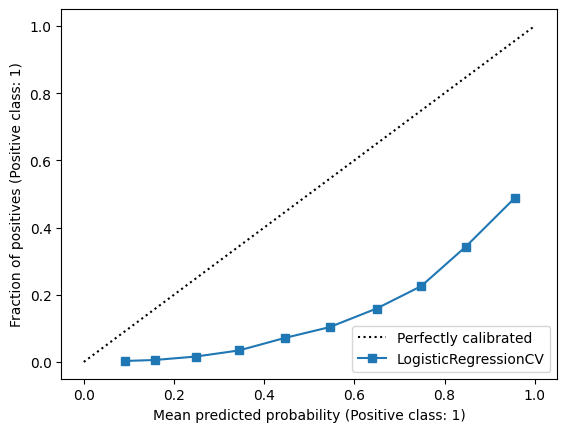

In [7]:
from sklearn.calibration import CalibrationDisplay

clf = log_reg_cv  # put model variable from last exercise here
X_test = X_test_processed  # put final X features matrix here
y_test = y_test_processed  # put final y labels array here

CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=10)

Krótko mówiąc, nie jest dobrze! Nasz model praktycznie zawsze bardzo mocno zaniża prawdopodobieństwo. W połączeniu z wysokim AUROC oznacza to, że w klasyfikacji generalnie nieźle sobie radzi, dla rosnącego prawdopodobieństwa dość szybko przypisuje punkt do klasy pozytywnej, ale finalne wartości prawdopodobieństw są notorycznie zbyt niskie.

Do poprawienia tej sytuacji służy `CalibratedClassifierCV`, który na podstawie predykcji naszego modelu oraz zbioru treningowego dotrenowuje dodatkowy model do doprecyzowania prawdopodobieństw. Może być to albo regresja logistyczna, albo tzw. regresja izotoniczna ([isotonic regression](https://scikit-learn.org/stable/modules/isotonic.html#isotonic)) - specjalny model wykorzystujący fakt, że prawdopodobieństwa są stricte rosnące od 0 do 1.

**Zadanie 3 (1 punkt)**

Wytrenuj kalibrator prawdopodobieństwa z pomocą `CalibratedClassifierCV`. Wykorzystaj tryb regresji izotonicznej i 10-krotną walidację skrośną. Przekaż do niego wytrenowany estymator wykorzystany w poprzednim ćwiczeniu. Narysuj krzywą kalibracji na zbiorze testowym, jak w poprzednim przykładzie.

Skomentuj, jak udało się poprawić kalibrację modelu. Czy twoim zdaniem taki model przewiduje już dość dobrze prawdopodobieństwa?

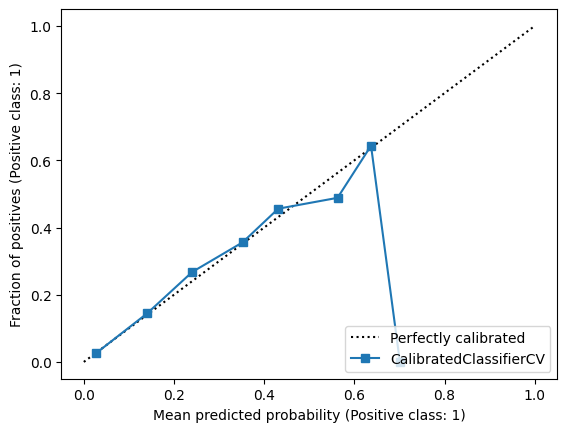

In [8]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(log_reg_cv, method='isotonic', cv=10)
calibrated_clf.fit(X_train_processed, y_train_processed)
CalibrationDisplay.from_estimator(calibrated_clf, X_test, y_test, n_bins=10)

Porównując wyniki do poprzedniego przykładu możemy zaobserwować znaczącą poprawę, jednak nie jest idealnie - dla dużego prawdopodobieństwa szansa na klasę pozytywną drastycznie maleje, co sprawia, że model nie jest użyteczny

## Detekcja spamu

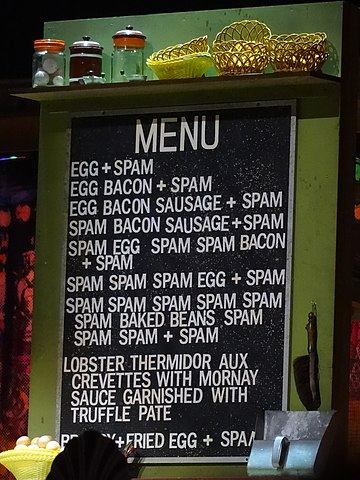

*(źródło: "Spam" sketch, Monty Python's Flying Circus)*

Wykorzystamy teraz klasyfikator Naiwnego Bayesa do klasyfikacji binarnej tekstów - czy email jest spamem, czy też nie (tzw. "ham"). Takie zadanie nazywa się też spam/ham classification. Zbiorem będzie [Enron Spam dataset](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html), zebrany na potrzeby artykułu:

> Metsis, Vangelis, Ion Androutsopoulos, and Georgios Paliouras. *"Spam filtering with Naive Bayes - which Naive Bayes?."* CEAS. Vol. 17. 2006. [link](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf)

[Upadek firmy energetycznej Enron](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf) i skandal wywołany wiadomościami o nieprawidłowościach finansowych spowodowały, że podczas śledztwa i procesu zmuszono firmę do upublicznienia pełnej zawartości skrzynek mailowych 150 pracowników. Jest to doskonałe źródło prawdziwych danych, typowych emaili niebędących spamem, i było wykorzystywane wielokrotnie na potrzeby tworzenia wielu różnych zbiorów danych. Na potrzeby powyższego artykułu wybrano 6 pracowników z dużą liczbą emaili.

Maile będące spamem otrzymano z 4 różnych źródeł:
1. [Zbioru danych SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/) - stworzony z pomocą [Apache SpamAssassin](https://spamassassin.apache.org/), narzędzia open source do detekcji spamu. Maile niebędące spamem są w nim bardzo specyficzne (pochodzą ze skrzynek fundacji Apache i dotyczą praktycznie tylko programownaia), za to spam jest uniwersalny.
2. [Project Honeypot](https://www.projecthoneypot.org/) - projekt mający na celu wykrywanie spammerów (w tym przez specjalne pułapki, tzw. spam baiting) i tworzenie baz do filtrowania spamu.
3. [Bazę spamu Bruce'a Guentera](http://untroubled.org/spam/) - gromadzi on cały spam, który dostaje na skrzynki (w tym takie do spam baitingu) od 1997 roku.
4. Maile ze spamem zgromadzone przez trzeciego autora artykułu, Georgiosa Paliourasa.

Artykuł prezentuje spersonalizowane kolekcje maili, dla każdego z 6 wybranych pracowników Enronu. My natomiast połączymy wszystkie dane i stworzymy prosty, uniwersalny filtr. Nasz filtr będzie operował tylko na tytułach i treści maili - realnie wdrażane systemy są dużo bardziej rozbudowane i wykorzystują metadane, bazy adresów, analizę tagów HTML i XML etc.

Wykorzystamy przetworzoną postać tego zbioru w postaci pliku CSV z interesującymi nas elementami. Skrypt do tego wzięto [z tego repozytorium na Githubie](https://github.com/MWiechmann/enron_spam_data?fbclid=IwAR1icPxic8TDD6HGk6empohwcZ76uig0NxwxK7sWbczinBNfxEEt-ETparA).

In [9]:
df = pd.read_csv("enron_spam_data.csv")
df

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


Na pierwszy rzut oka widać parę problemów:
- kolumny `Message ID` i `Date` są niepotrzebne
- niektóre wiadomości mają tylko tytuł lub tylko wiadomość
- klasa jest zapisana jako string spam/ham

**Zadanie 4 (0.5 punktu)**

1. Uzupełnij wartości brakujące w kolumnach `Subject` i `Message` pustymi stringami.
2. Połącz kolumny `Subject` i `Message` w jedną kolumnę `text`, ze spacją pomiędzy nimi. Może się przydać metoda `pd.Series.str.cat()`. Wyodrębnij ją do nowej zmiennej `texts`.
3. Zamień wartość `ham` na 0 i `spam` na 1 w kolumnie `Spam/Ham`. Wyodrębnij ją do nowej zmiennej `y`.

In [10]:
df["Subject"].fillna("", inplace=True)
df["Message"].fillna("", inplace=True)

texts = df["Subject"].str.cat(df["Message"], sep=" ")

y = df["Spam/Ham"].map({"ham": 0, "spam": 1})

C:\Users\Marcel\AppData\Local\Temp\ipykernel_7520\1679239426.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Subject"].fillna("", inplace=True)
C:\Users\Marcel\AppData\Local\Temp\ipykernel_7520\1679239426.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

Sprawdźmy jeszcze rozkład klas.

[Text(0, 0, '50.93'), Text(0, 0, '49.07')]

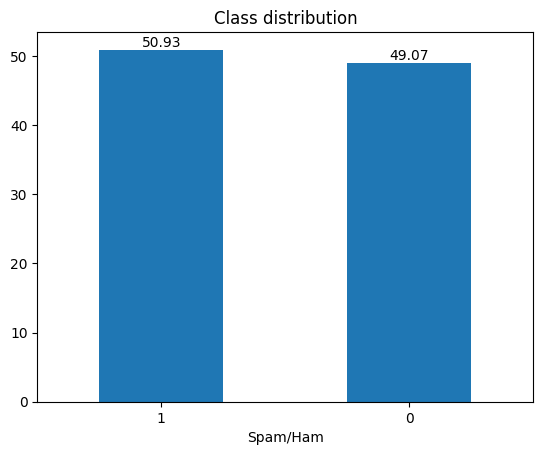

In [11]:
class_percentages = y.value_counts(normalize=True)
class_percentages = round(class_percentages * 100, 2)

ax = class_percentages.plot.bar(title="Class distribution", rot=0)

ax.bar_label(ax.containers[0])

Ten zbiór w całości jest o tyle specyficzny, że dodano tutaj aż tyle spamu, że jest go nawet więcej niż zwykłych emaili. W praktyce spamu jest dużo mniej, ok. 1/3 maili. Tutaj uznajemy, że klasy są zbalansowane.

Typową metryką w klasyfikacji spamu jest **precyzja (precision)**, bo wyznacza ona, jak dobrzy jesteśmy w oznaczaniu spamu. Recall ma mniejsze znaczenie, bo bardziej zależy nam na minimalizacji FP - ważne maile nie mogą trafiać do spamu, natomiast jeżeli spam czasem trafi do zwykłej skrzynki (FN), to nie ma wielkiego znaczenia. Często używa się też F1-score jako metryki.

W przypadku tych metryk (precision/recall/F1-score) zawsze trzeba sprawdzić co najmniej dwie z nich, żeby uniknąć przypadkiem sytuacji, że mamy np. precision bliskie 100%, a dramatycznie niski recall - to też nie byłoby akceptowalne. Trzeba też uważać podczas walidacji skrośnej - np. klasyfikator przewidujący cały czas klasę pozytywną miałby 100% recall, a cały czas negatywną 100% precision, więc typowo najwygodniej jest optymalizować F1-score.

Na początek podzielimy zbiór na treningowy i testowy. Naszymi cechami będą zliczenia wystąpień poszczególnych słów, obliczone z pomocą klasy `CountVectorizer` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)). Na start podamy `binary=True`, dzięki czemu cechy będą binarne - czy słowo wystąpiło, czy nie. Dzięki temu będziemy mogli użyć Naiwnego Bayesa z rozkładem dwumianowym - `BernoulliNB`. Wykonamy minimalny preprocessing, usuwając tylko tzw. stop words, czyli "nudne", niepotrzebne słowa, typu "he", "she", "the" etc.

Zauważ, że wejściem do metody `.fit()` jest lista tekstów, ze względu a domyślne `input="content"`. Można by tu też wskazać listę ścieżek do plików z tekstami (`input="filename"`).

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


texts_train, texts_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

count_vectorizer = CountVectorizer(
    stop_words="english",
    binary=True,
)
count_vectorizer.fit(texts_train)

X_train = count_vectorizer.transform(texts_train)
X_test = count_vectorizer.transform(texts_test)

print(f"Dictionary size: {X_train.shape[1]}")

clf_nb_bernoulli = BernoulliNB(binarize=None)
clf_nb_bernoulli.fit(X_train, y_train)

y_pred = clf_nb_bernoulli.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Dictionary size: 139189
Precision: 98.92%
F1-score: 98.46%


Wynik jest prawie doskonały. Może uda się jeszcze wycisnąć ten ostatni procent?

**Zadanie 5 (2 punkty)**

1. Oblicz wystąpienia słów bez binaryzacji, otrzymując drugi zbiór cech.
2. Wytrenuj model multinomial Naive Bayes na otrzymanym zbiorze. Sprawdź precyzję i F1-score na zbiorze testowym.
3. Stwórz `Pipeline` z połączenia `CountVectorizer` i `MultinomialNB`. Podaj te opcje, co wcześniej do CountVectorizera.
4. Dokonaj tuningu hiperparametrów:
   - `ngram_range` - jakie n-gramy rozważać, sprawdź wartości `[(1, 1), (1, 2), (1, 3)]` (same słowa, + bigramy, + bigramy i trigramy)
   - `max_df` - w jakim maksymalnie ułamku tekstów w zbiorze może wystąpić słowo, sprawdź wartości `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`
   - wybierz model o najwyższej precyzji
   - użyj standardowych ustawień: 5-krotna walidacja skrośna, `n_jobs=-1`
   - sprawdź precyzję i F1-score na zbiorze testowym dla znalezionych optymalnych hiperparametrów
5. Wypisz optymalne hiperparametry. Sprawdź, jak zmienił się rozmiar słownika przy tych hiperparametrach.
6. Skomentuj uzyskane hiperparametry. Jaki zakres (kontekst) uwzględniamy przy takich n-gramach? Czy uwzględniamy wszystkie słowa/bigramy/trigramy?

**Uwaga:**
1. Do metody `.fit()` możesz przekazać `texts_train` i `y_train`. Jako że `CountVectorizer` ma interfejs transformera (ma metodę `.transform()`), to Scikit-learn przekształci nim teksty do macierzy `X_train` i to ją przekaże dalej do klasyfikatora.
2. Przy tworzeniu pipeline'u może się przydać [ta odpowiedź na StackOverflow](https://stackoverflow.com/a/64258746/9472066).
3. Pamiętaj, że do testowania też trzeba przekazać teksty, które przekształcimy w środku pipeline'u.

In [24]:
from sklearn.naive_bayes import MultinomialNB

count_vectorizer_nb = CountVectorizer(stop_words="english")

X_train_nb = count_vectorizer.fit_transform(texts_train)
X_test_nb = count_vectorizer.transform(texts_test)

mulitnomial_clf = MultinomialNB()
mulitnomial_clf.fit(X_train_nb,y_train)

y_pred_nb = mulitnomial_clf.predict(X_test_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Precision for MultinomialNB: {100 * precision_nb:.2f}%")
print(f"F1-score for MultinomialNB: {100 * f1_nb:.2f}%")



Precision for MultinomialNB: 99.02%
F1-score for MultinomialNB: 98.75%


In [28]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("vectorizer", CountVectorizer(stop_words="english")),
    ("classifier", MultinomialNB())
])

params = {
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "vectorizer__max_df": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(pipeline, params, scoring='precision', cv=5, n_jobs=-1)
grid_search.fit(texts_train, y_train)

best_params = grid_search.best_params_

In [29]:
print(best_params)

{'vectorizer__max_df': 0.5, 'vectorizer__ngram_range': (1, 3)}


In [32]:
best = grid_search.best_estimator_

y_pred_best = best.predict(texts_test)
precision = precision_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Precision for best result: {100 * precision:.2f}%")
print(f"F1-score for best result: {100 * f1:.2f}%")
print(f"Dict size: {len(best.named_steps['vectorizer'].vocabulary_)}")

Precision for best result: 99.32%
F1-score for best result: 99.24%
Dict size: 3383053


Wynik jest niemal doskonały.

W przypadku tak wysokich wyników raczej nie ma sensu sprawdzać bardziej złożonych technik, typu ważenie słów (TF-IDF, BM25), upraszczanie słów (stemming, lematyzacja) etc. W przypadku bardziej złożonych tekstów mogłoby to być przydatne.

Naiwnego Bayesa do klasyfikacji tekstu używa się obecnie relatywnie rzadko. Potrafi on jednak działać równie dobrze, jak transformery, kiedy dla danego zadania mają znaczenie same wystąpienia słów czy tematyka tekstu, a nie dokładna semantyka zdań. Naiwny Bayes jest przy tym oczywiście bez porównania prostszy i szybszy.

## Dane z ekspresji genów

Naszym ostatnim zbiorem będzie [GSE2034](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse2034) ([Mendeley Data](https://data.mendeley.com/datasets/v3cc2p38hb/1), [Kaggle](https://www.kaggle.com/datasets/saurabhshahane/gene-expression-profiles-of-breast-cancer)). Jest to zbiór ekspresji genów z sekwencjonowania RNA, zebrany na potrzeby artykułu:

> Wang, Yixin, et al. *"Gene-expression profiles to predict distant metastasis of lymph-node-negative primary breast cancer."* The Lancet 365.9460 (2005): 671-679. [link](https://www.ihes.fr/~zinovyev/princmanif2006/Wang_lancet_2005.pdf)

Zbiór ten został stworzony z danych pochodzących z sekwencjonowania RNA 286 pacjentek chorych na nowotwór piersi bez przerzutów do węzłów chłonnych ([lymph node-negative breast cancer](https://www.komen.org/breast-cancer/diagnosis/stages-staging/lymph-node-status/)). Celem było sprawdzenie, czy na podstawie analizy genetycznej można przewidzieć, czy nastąpi odległa metastaza nowotworu ([distant metastatis](https://training.seer.cancer.gov/staging/systems/summary/distant.html)), czyli przerzuty nowotworu przez krew do odległych części ciała. Takie przypadki uznaje się za porażkę w leczeniu nowotworu. Według źródeł z artykułu, ok. 85-90% pacjentek jest poddawane dodatkowej terapii (np. chemoterapii) po operacji usunięcia nowotworu, natomiast personalizowana medycyna oparta o analizę genetyczną pozwoliłaby nie tylko oszczędzić tego leczenia (z ciężkimi skutkami ubocznymi) niektórym pacjentkom, ale też skupić się bardziej na innych, z większym ryzykiem przerzutów.

Cechy w tym zbiorze to poziom ekspresji 12634 genów w sekwencjonowanym RNA. Ekspresja genu ([gene expression](https://en.wikipedia.org/wiki/Gene_expression)) to proces tłumaczenia informacji genetycznej z genu (sekwencji DNA) do białek (przez kodujące RNA) lub innych funkcji (przez niekodujące RNA). Im silniejsza ekspresja genu, tym więcej materiału (zwykle białek / protein) produkuje dany gen w danym organizmie. Jest to najmniejszy molekularnie poziom, na którym można zaobserwować fenotyp, czyli cechy stworzone na podstawie genotypu.

Oprogramowanie do analizy ekspresji genów dokonuje od razu standaryzacji poziomu ekspresji każdego z genów. W związku dla każdego z genów mamy jego Z-score, czyli wartość cechy oznacza, o ile odchyleń standardowych jego wartość różni się od średniej ekspresji tego genu wśród wszystkich próbek. Jest to wygodne do analiz biomedycznych, bo pozwala bezpośrednio porównywać ze sobą pacjentów. Przy okazji jest też wygodne do uczenia maszynowego.

Zmienną do przewidywania jest tutaj, czy nastąpi nawrót nowotworu i przerzuty w ciągu 5 lat od operacji (to podczas niej pobiera się tkankę nowotworową do badań genetycznych). Warto zwrócić uwagę, że mamy tutaj 286 pacjentek, a ponad 12 tysięcy cech, a zatem $n >> d$.

W przypadku danych medycznych typowo optymalizowaną metryką jest **czułość (recall)**, ponieważ zależy nam na tym, żeby minimalizować przypadki FN. Oznaczają one brak wykrycia choroby, co ma tragiczne skutki, w przeciwieństwie do FP, które może mieć co prawda negatywne skutki (np. dodatkowe badania, niepotrzebne leczenie ze skutkami ubocznymi), ale typowo mniejsze. Oczywiście dalej trzeba sprawdzić F1-score.

**Zadanie 6 (0.5 punktu)**

1. Wczytaj dane z plików `GSE2034-Normal.tsv` oraz `GSE2034-Tumor.tsv`. Są one w formacie TSV, czyli CSV, ale z tabami (`\t`) zamiast przecinków.
2. Usuń kolumnę `Hybridization REF` z obu ramek.
3. Obecnie kolumny to pacjentki, a wiersze to ekspresje genów. Dokonaj transpozycji (transpose) DataFrame'ów tak, aby kolumnami były cechy.
4. Połącz oba DataFrame'y w jedną tablicę Numpy'a `X`, reprezentującą cały zbiór danych.
5. Stwórz wektor klas `y`, mający wartości 0 dla wierszy z pliku `Normal` i wartość 1 dla wierszy z pliku `Tumor`.
6. Narysuj wykres częstości klas.

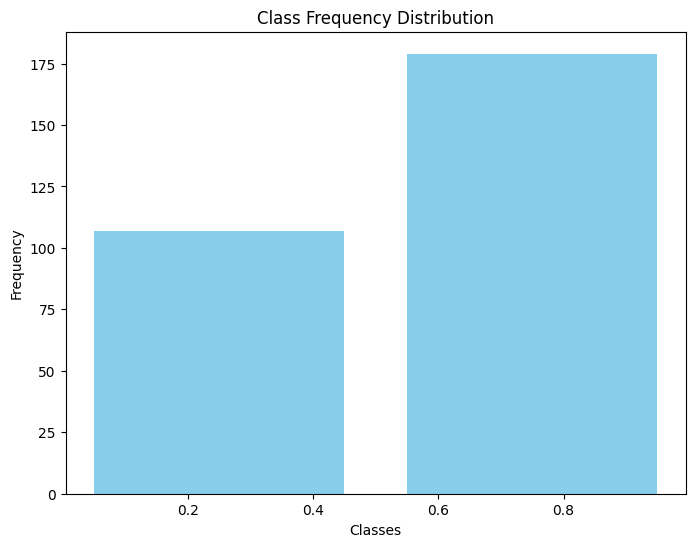

In [33]:
normal = pd.read_csv('GSE2034-Normal.tsv', sep='\t')
tumor = pd.read_csv('GSE2034-Tumor.tsv', sep='\t')

normal.drop(columns=['Hybridization REF'], inplace=True)
tumor.drop(columns=['Hybridization REF'], inplace=True)

normal = normal.transpose()
tumor = tumor.transpose()

X = np.vstack((normal, tumor))

y = np.array([0] * normal.shape[0] + [1] * tumor.shape[0])

plt.figure(figsize=(8, 6))
plt.hist(y, bins=2, rwidth=0.8, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution')
plt.show()

Jak widać, mamy więcej przykładów pozytywnych niż negatywnych. Jest to dość częste w zbiorach medycznych, które są często tworzone bardziej do analizy przypadków chorobowych, niż do tworzenia modeli predykcyjnych. Oczywiście to, że klasy pozytywnej jest więcej, wcale nie oznacza, że klasyfikacja musi być prostsza.

Jako że nasze cechy są ciągłe, to musimy użyć klasyfikatora Naiwnego Bayesa z założeniem rozkładu normalnego do klasyfikacji. Dokonamy podziału na zbiór treningowy i testowy w proporcjach 67%-33%.

In [34]:
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=0,
    stratify=y,
)

clf_nb_gaussian = GaussianNB()
clf_nb_gaussian.fit(X_train, y_train)

y_pred = clf_nb_gaussian.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Recall: 64.41%
F1-score: 68.47%


Wyniki są co najwyżej mocno przeciętne. Można powiedzieć, że mamy tu underfitting, ale przy tej ilości danych (zbiór treningowy ma ok. 200 próbek) użycie dużo pojemniejszego modelu mogłoby się łatwo skończyć się mocnym overfittingiem.

Może to nasze założenia co do normalności klas są błędne? Sprawdźmy to dla kilku pierwszych cech.

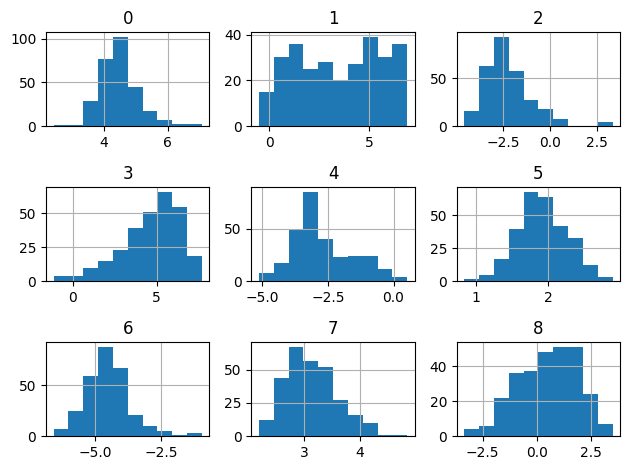

In [35]:
pd.DataFrame(X[:, :9]).hist()
plt.tight_layout()
plt.show()

O ile niektóre rozkłady nieco przypominają normalny, co tłumaczy nie najgorszy wynik klasyfikatora, to jednak daleko do pełnej normalności. Empiryczne oszacowanie rozkładu za pomocą Kernel Density Estimation (KDE) powinno poprawić wynik w takiej sytuacji.

Scikit-learn nie ma gotowego Naive Bayesa z KDE, ale łatwo go zaimplementować. W tym celu trzeba stworzyć własny klasyfikator. Robi się w skrócie to tak ([dokładny tutorial](https://scikit-learn.org/stable/developers/develop.html)):
1. Tworzymy klasę dziedziczącą po `BaseEstimator`, `ClassifierMixin` oraz ewentualnie innych klasach, które nas interesują.
2. Wszystkie hiperparametry są argumentami konstruktora. Każdy jest przypisywany, bez żadnych zmian, do atrybutu o dokładnie tej samej nazwie.
3. Implementujemy metody `.fit(X, y)`,`.predict(X)`, oraz ewentualnie `.predict_proba(X)`. Metoda `.fit()` musi zwracać `self`.
4. Na początku metody `.fit(X, y)` używamy funkcji `check_X_y()`, żeby dokonać podstawowej walidacji wejścia. Na początku metody `.predict(X)` analogicznie używamy funkcji `check_array()` na wejściu `X`.

Taki interfejs gwarantuje, że nasz własny model będzie mógł być używany np. w `GridSearchCV`.

**Zadanie 7 (2.5 punktu)**

Uzupełnij implementację klasy `KernelDensityEstimationNB`, realizującej algorytm KDE Naive Bayes.

1. Zakładamy, że klasy są liczbami całkowitymi, z wartościami `[0, 1, ..., liczba klas - 1]`.
2. Rozkład a priori (prior) dla każdej klasy to proporcja tej klasy w zbiorze treningowym. Naive Bayes używa log-sum-exp trick, więc można od razu obliczyć logarytm i zapisać log-prior.
3. Każda klasa ma swój model Kernel Density Estimation, wytrenowany na przykładach z tej klasy.
4. Podczas predykcji trzeba obliczyć, dla każdej z nowych próbek do zaklasyfikowania, jej wiarygodność (likelihood) dla każdej z klas. Służy do tego metoda `.score_samples()`. Ze względu na log-sum-exp trick ponownie oblicza się logarytm, otrzymując log-likelihood.
5. Dla każdego z przykładów, dla każdej z klas, sumujemy log-prior i log-likelihood, otrzymując wartość rozkładu a posteriori (posterior). Zgodnie z zasadą maximum a posteriori (MAP), wybieramy klasę o najwyższej z tych wartości. Może tu się przydać `np.argmax()`.

In [48]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.utils import check_array, check_X_y


class KernelDensityEstimationNB(BaseEstimator, ClassifierMixin):
    """
    Naive Bayes with KDE estimation of feature distributions.

    Parameters
    ----------
    kernel : str
        Kernel name, passed to KernelDensity

    bandwidth : float
        Kernel bandwidth
    """

    def __init__(self, kernel: str = "gaussian", bandwidth: float = 1.0):
        # create attributes
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, y):
        # make sure that we are working on Numpy arrays, and perform basic
        # sanity checks
        X = np.array(X)
        y = np.array(y)
        X, y = check_X_y(X, y)

        # make sure that y has values from 0 to num_classes - 1
        assert y.min() == 0
        assert y.max() == len(np.unique(y)) - 1

        # vector of possible classes
        self.classes_ = np.sort(np.unique(y))

        # vector for remembering class priors, i.e. proportion of classes
        # in the training set
        self.log_priors_ = np.empty(len(self.classes_))

        # list of KernelDensity models, one for each class
        self.kde_models_ = []

        for class_idx in self.classes_:
            # select X and y from the current class
            class_mask = (y == class_idx)
            X_class = X[class_mask]
            y_class = y[class_mask]

            # calculate log-prior, i.e. logarithm of current class proportion
            self.log_priors_[class_idx] = np.log(X_class.shape[0] / X.shape[0])

            # create and fit KernelDensity estimator, using given kernel and bandwidth
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
            kde.fit(X_class)
            # save KDE
            self.kde_models_.append(kde)

        return self

    def predict(self, X):
        # make sure that we are working on Numpy array, and perform basic
        # sanity checks
        X = np.array(X)
        X = check_array(X)

        # use KDE models and calculate log-likelihoods for each sample
        log_likelihoods = np.array([kde.score_samples(X) for kde in self.kde_models_]).T

        # calculate posterior probability: log-prior + log-likelihood
        # make sure that they have the same shape (transpose if needed)
        posteriors = log_likelihoods + self.log_priors_

        # select the index of class with maximum a posteriori (MAP) rule
        map_class = self.classes_[np.argmax(posteriors, axis=1)]

        return map_class

In [49]:
clf_nb_kde = KernelDensityEstimationNB()
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Recall: 84.75%
F1-score: 70.92%


W przypadku czułości (recall) jest już zdecydowanie lepiej! F1-score poprawił się, ale tylko trochę - precyzja mogłaby być lepsza. Ale KDE jest dość czułe na dobór szerokości (bandwidth) kernela, więc tuning hiperparametrów powinien tutaj pomóc.

Ciekawą opcją dla szerokości kernela jest **Silverman's rule of thumb**. Jest to prosty wzór na szerokość kernela przy założeniu, że rozkład jest unimodalny. Scikit-learn wspiera tę opcję przez przekazanie wartości `bandwidth="silverman"`. Wzór dla wielu cech ([Wikipedia](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Rule_of_thumb)):

$$
h_{silverman} = \left(\frac{4}{d+2}\right) n^{\frac{-1}{d+4}} \sigma
$$

Gdzie $\sigma$ to wektor odchyleń standardowych cech, $n$ to liczba próbek, a $d$ to liczba wymiarów.

Wadą implementacji w Scikit-learn jest to, że nie uwzględnia on odchyleń $\sigma$, więc bandwidth jest wspólny dla wszystkich cech. Jeżeli jednak są one w podobnej skali (tak jak w tym zbiorze), to nie stanowi to dużego problemu. No i w razie potrzeby można zawsze ustandardyzować dane.

Dla zainteresowanych - tuning kernel bandwidth to mocno badane przez matematyków zagadnienie, i istnieje do niego szereg rozbudowanych metod statystycznych. [Ten tutorial](https://aakinshin.net/posts/kde-bw/) jest chyba najlepszym i najbardziej czytelnym, a przy tym ma potężny przegląd literatury.

In [50]:
clf_nb_kde = KernelDensityEstimationNB(bandwidth="silverman")
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

class_0_bandwidth = clf_nb_kde.kde_models_[0].bandwidth_
class_1_bandwidth = clf_nb_kde.kde_models_[1].bandwidth_

print(f"Class bandwidths: {class_0_bandwidth:.4f}, {class_1_bandwidth:.4f}")

Recall: 86.44%
F1-score: 72.34%
Class bandwidths: 0.9990, 0.9990


Wynik się poprawił, a ilość pracy była minimalna. Jeżeli nasze rozkłady cech wyglądają na unimodalne i podobne do normalnego, to zasada Silvermana może w prosty i szybki sposób ulepszyć nasze wyniki.

Dodatkowo widać, że wyestymowany bandwidth jest bardzo bliski 1 (korekta jest zasadniczo kosmetyczna), więc w tym obszarze można ewentualnie szukać lepszych wartości hiperparametru.

**Zadanie 9 (1 punkt)**

1. Dokonaj tuningu hiperparametru `bandwidth`:
   - sprawdź 100 wartości na siatce liniowej w zakresie od 0.75 do 1.25
   - użyj kernela gaussowskiego
   - wybierz model o najwyższym F1-score
   - użyj standardowych ustawień: 5-krotna walidacja skrośna, `random_state=0`, `n_jobs=-1`
2. Wypisz znalezioną optymalną wartość szerokości kernela.
3. Sprawdź czułość (recall) i F1-score na zbiorze testowym dla znalezionych optymalnych hiperparametrów.
4. Czy optymalna wartość kernela była większa, czy mniejsza od domyślnego 1? Czy takie oszacowanie KDE ma bardziej gładki kształt (większy bias), czy bardziej zróżnicowany (większa wariancja)?
4. Czy udało się poprawić wynik? Czy takie wartości metryk uważasz za zadowalające?

In [51]:
clf_nb_kde = KernelDensityEstimationNB(kernel='gaussian')

params = {'bandwidth': np.linspace(0.75, 1.25, 100)}

grid_search = GridSearchCV(clf_nb_kde, params, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Best bandwidth: {best_params['bandwidth']:.4f}")
print(f"Besr Recall: {100 * recall:.2f}")
print(f"F1-score: {100 * f1:.2f}")



Best bandwidth: 1.2045
Besr Recall: 91.53
F1-score: 76.06


Optymalna wartość okazała się większa od 1. Wynik udało się poprawić


## Zadanie dodatkowe (3 punkty)

Najpopularniejszą techniką nieparametryczną, która pozwala oszacować szerokość kernela, jest **estymator Sheathera-Jonesa (Sheather-Jones estimator)**. Używa on dość zaawansowanej statystyki, aby zminimalizować błąd średniokwadratowy między oszacowaniem KDE a prawdziwym (nieznanym) rozkładem. Typowo daje dużo lepsze wyniki od reguły Silvermana, bo wiele cech nie jest unimodalnych i/lub zbliżonych do rozkładu normalnego.

Dodatkowo KDE w postaci ze Scikit-learn, używające wprost definicji i opierające się na najbliższych sąsiadach, nie jest zbyt szybkie. Można pokazać, że sumowanie kerneli z każdego punktu odpowiada operacji **konwolucji (convolution)**, a dzięki temu można wykorzystać **twierdzenie o splocie (convolution theorem)** i obliczyć to za pomocą szybkiej transformaty Fouriera (FFT). Algorytm FFTKDE jest rzędy wielkości szybszy od tradycyjnego podejścia, i świetnie się skaluje.

Oba te mechanizmy implementuje biblioteka [KDEpy](https://kdepy.readthedocs.io/en/latest/index.html), z interfejsem bardzo podobnym do Scikit-learn.

1. Zaimplementuj KDE Naive Bayesa z pomocą algorytmu FFTKDE.
2. Zastosuj estymator Sheathera-Jonesa do oszacowania szerokości kernela. Czy wynik jest lepszy, czy gorszy od tego z zasady Silvermana oraz z walidacji skrośnej?
3. Wczytaj zbiór Cod-RNA z laboratorium 3. Wytrenuj na nim algorytmy:
   - Gaussian NB
   - KDE NB
   - FFTKDE NB
4. Porównaj wyniki oraz czas treningu. Czy warto było tutaj zastosować algorytm FFTKDE?
5. Dokonaj tuningu szerokości kernela za pomocą metod: Silvermana, Sheathera-Jonesa oraz walidacji skrośnej. Które daje najlepszy wynik?